In [1]:
import CSV
using DataFrames
# using StatsBase
include("pred_funcs.jl")
using MLJ
# import MLJBase
import TableView.showtable
using Plots
import FileIO
import Statistics

WebIO._IJuliaInit()

In [2]:
using Turing, Distributions


# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

using Random
Random.seed!(0);

using StatsBase
import MLJBase
# setprogress!(true)

In [3]:
MissingImputator = @load MissingImputator pkg="BetaML"

XGBoostClassifier = @load XGBoostClassifier;  # loads code defining a model type
LogisticClassifier = @load LogisticClassifier pkg="MLJLinearModels";  # loads code defining a model type
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier;  # loads code defining a model type
EvoTreeClassifier = @load EvoTreeClassifier
GradientBoostingClassifier = @load GradientBoostingClassifier
EvoTreeGaussian = @load EvoTreeGaussian
SVC = @load SVC

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


import BetaML ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


import MLJXGBoostInterface ✔
import MLJLinearModels ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168



import MLJDecisionTreeInterface ✔
import EvoTrees ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168



import MLJScikitLearnInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168



import EvoTrees ✔
import MLJLIBSVMInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


MLJLIBSVMInterface.SVC

In [434]:
sample_key, xold, yold = FileIO.load("cleaned_data.jld2","sample_key","x" ,"y");
xold.col1=collect(1:nrow(xold));

In [435]:
for j in 1:ncol(xold), i in 1:nrow(xold)
    if !ismissing(xold[i,j]) && (isnan(xold[i,j]) || isinf(xold[i,j]) )
        xold[i,j] = missing
    end
end

In [436]:
# filter!(x->ismissing(x.gt_AF_Vardict) || x.gt_AF_Vardict>0.001,xold);
# println(nrow(xold))
# filter!(x->ismissing(x.gt_AF_Lofreq) || x.gt_AF_Lofreq>0.001,xold);
# println(nrow(xold))
# filter!(x->ismissing(x.gt_AF_Mutect) || x.gt_AF_Mutect>0.001,xold);
# println(nrow(xold))
# filter!(x->ismissing(x.gt_AF_Pindel) || x.gt_AF_Pindel>0.001,xold);
# println(nrow(xold))

In [437]:
# xindel = filter(xs->xs.REF_I>0.5 || xs.ALT_I>0.5, xold);

In [438]:
# yindel = y[xindel.col1];
# select!(xindel,Not(:col1));

In [439]:
xsnv = filter(xs->xs.REF_I<0.5 && xs.ALT_I<0.5, xold);

In [440]:
size(xsnv)

(61776, 96)

In [441]:
ysnv = yold[xsnv.col1];
sample_keysnv = sample_key[xsnv.col1];
select!(xsnv,Not(:col1));


In [442]:
coldrop = []
for nam in names(xsnv)
    msval = sum(ismissing.(xsnv[:,nam]))/nrow(xsnv)
    if msval > 0.9
        println(nam," ", msval) 
        push!(coldrop, nam)
    elseif length(unique(xsnv[:,nam])) == 1
        println(nam) 
        push!(coldrop, nam)
    end
end
for i in names(xsnv)
    if occursin("Pind",i) || occursin("ALT",i) || occursin("REF",i)
     
        push!(coldrop,i)
#         println(i)
    end
end
unique!(coldrop);

gt_AD_alt_Pindel 1.0
gt_AD_ref_Pindel 1.0
gt_AF_Pindel 1.0
pon_pvalue_Pindel 1.0
total_greater_than_min_alt_count_Pindel 1.0
dust_score_Pindel 1.0
dust_score_3_Pindel 1.0
dust_score_5_Pindel 1.0
dust_score_10_Pindel 1.0
total_Pindel 1.0
gt_AD_alt_Lofreq 0.9719632219632219
ref_len
alt_len
REF_I
ALT_I


In [443]:
select!(xsnv, Not(coldrop));
println(size(xsnv))

(61776, 72)


In [444]:
names(xsnv)

72-element Vector{String}:
 "QUAL_Vardict"
 "PMEAN_Vardict"
 "SBF_Vardict"
 "ODDRATIO_Vardict"
 "SN_Vardict"
 "HIAF_Vardict"
 "ADJAF_Vardict"
 "SHIFT3_Vardict"
 "NM_Vardict"
 "HICNT_Vardict"
 "HICOV_Vardict"
 "gt_AD_alt_Vardict"
 "gt_AD_ref_Vardict"
 ⋮
 "fwdbias_Mutect"
 "revbias_Mutect"
 "fwdbias_Lofreq"
 "revbias_Lofreq"
 "fwdbias_Vardict"
 "revbias_Vardict"
 "MBQ_Mutect_1"
 "MBQ_Mutect_2"
 "MFRL_Mutect_1"
 "MFRL_Mutect_2"
 "MMQ_Mutect_1"
 "MMQ_Mutect_2"

In [445]:
train2 = findall(x->x,[i>0.5 for i in xsnv.training])
test = findall(x->x,[i<0.5 for i in xsnv.training])
select!(xsnv,Not("training"))
# train2, test = partition(eachindex(ysnv), 0.7, stratify=ysnv,  shuffle=true, rng=12344);

In [446]:
println(length(test)," ",sum([i==true for i in ysnv]) )

42031 135


In [447]:
xtemp = copy(xsnv);
ytemp = copy(ysnv);

In [448]:
transform_standardizer!(xtemp,fit_standardizer(xtemp[train2,:]));

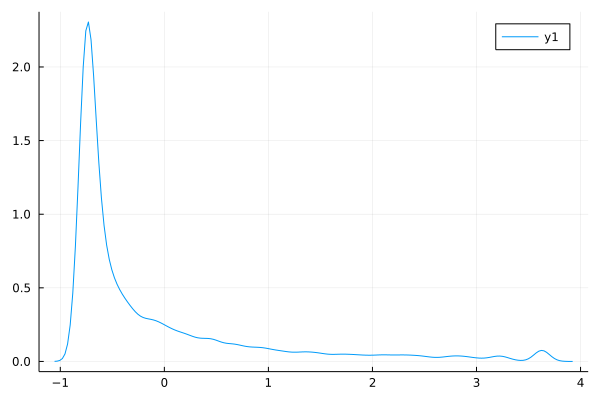

In [449]:
density(collect(skipmissing(xtemp.pon_pvalue_Vardict)))

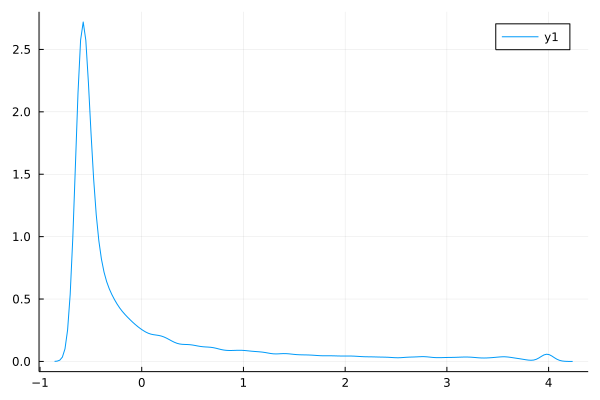

In [452]:
density(collect(skipmissing(xtemp.pon_pvalue_Lofreq)))

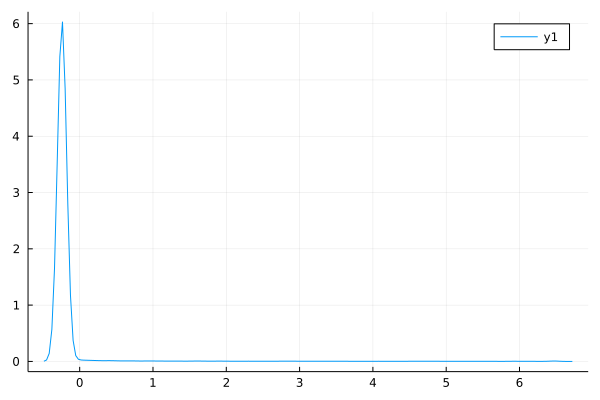

In [453]:
density(collect(skipmissing(xtemp.pon_pvalue_Mutect)))

In [454]:
stmach = machine(MissingImputator(K=15),xtemp[train2,:]) 
@time sttran = fit!(stmach,verbosity=1)

┌ Info: Training Machine{MissingImputator,…} @107.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391


 18.549051 seconds (152.17 M allocations: 16.232 GiB, 14.92% gc time, 0.87% compilation time)


Machine{MissingImputator,…} @107 trained 1 time; caches data
  args: 
    1:	Source @143 ⏎ `Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Union{Missing, ScientificTypesBase.Continuous}}}}`


In [455]:
tt = MLJ.transform(sttran,xtemp);

In [456]:
train = copy(train2)
x = copy(xtemp);
y = copy(ytemp);

In [457]:
for i in 1:ncol(x)
    x[:,i] = tt[i]
end

In [458]:
disallowmissing!(x);

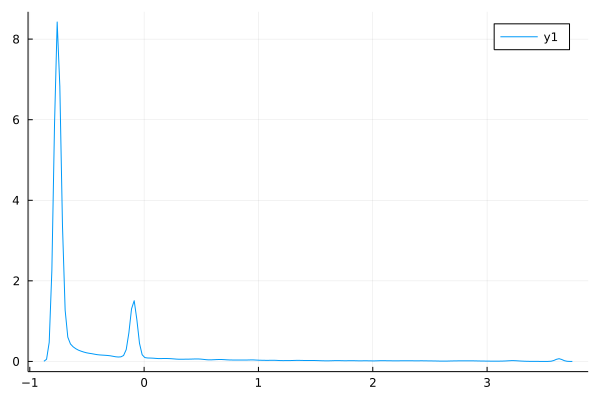

In [459]:
density(x.pon_pvalue_Vardict)

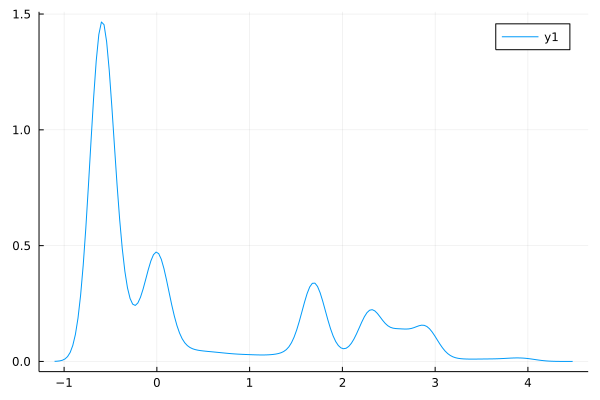

In [462]:
density(x.pon_pvalue_Lofreq)

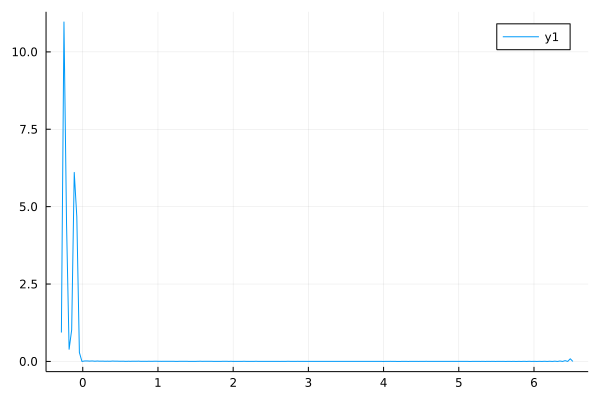

In [461]:
density(x.pon_pvalue_Mutect)

In [463]:
println(length(test)," ",sum([i==true for i in y[train]]) )

42031 41


In [474]:

x,y,train = sampler(x,y,train,"over",0.1);

ratio: 0.002080795777507105
number of new: 1929


In [475]:
println(length(test)," ",sum([i==true for i in y[test]]) )
println(length(test)," ",sum([i==true for i in y[train]]) )

42031 94
42031 1970


In [476]:
y = coerce(copy(y),OrderedFactor);

# ===

In [477]:
# info(SVC)

In [478]:

r = [
    range(EvoTreeClassifier(), :max_depth, lower=1,upper=4),
    range(EvoTreeClassifier(), :η, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :γ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :λ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :α, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :min_weight, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :nrounds, lower=1,upper=10),
    
    
#     range(LogisticClassifier(), :lambda, lower=0.0,upper=1.0),
#     range(LogisticClassifier(), :gamma, lower=0.0,upper=1.0),
    
#     range(SVC(), :degree, lower=1,upper=4),
#     range(SVC(), :gamma, lower=0.0,upper=1.0),    
]

7-element Vector{MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T}:
 typename(MLJBase.NumericRange)(Int64, :max_depth, ... )
 typename(MLJBase.NumericRange)(Float64, :η, ... )
 typename(MLJBase.NumericRange)(Float64, :γ, ... )
 typename(MLJBase.NumericRange)(Float64, :λ, ... )
 typename(MLJBase.NumericRange)(Float64, :α, ... )
 typename(MLJBase.NumericRange)(Float64, :min_weight, ... )
 typename(MLJBase.NumericRange)(Int64, :nrounds, ... )

In [486]:
self_tune = TunedModel(
#     model=LogisticClassifier(penalty=:l2),
#     model=SVC(),
    model=EvoTreeClassifier(),
    resampling=StratifiedCV(nfolds=5, rng=123),

    tuning=LatinHypercube(),  #     tuning=Grid(resolution=2), 
    range = r,
    n=50,
    operation=predict_mode, # use for probabalistic 
    measure = fnr,  # use for deterministic or with predict_mode for probab 
#     measure = brier_loss # use for probabalistic 
    acceleration=CPUThreads(),
)

machbest = machine(self_tune,x[train,:],y[train])
fit!(machbest,verbosity=1 )
# evaluate!(machbest,verbosity=2,resampling=StratifiedCV(nfolds=5, rng=123), acceleration=CPUThreads() )
# MLJ.save("xgb_varscan.jlso", machbest)

┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…} @701.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/machines.jl:391
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:12


Machine{ProbabilisticTunedModel{LatinHypercube,…},…} @701 trained 1 time; caches data
  args: 
    1:	Source @347 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @236 ⏎ `AbstractVector{OrderedFactor{2}}`


In [487]:
yhat=MLJ.predict_mode(machbest, x[test,:]);
# yhat=MLJ.predict(machbest, x[test,:]);

In [488]:
ConfusionMatrix()(yhat,y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    38920    │     92      │
├─────────────┼─────────────┼─────────────┤
│    true     │    3017     │      2      │
└─────────────┴─────────────┴─────────────┘


In [33]:
aa = DataFrame(x1=yhat,x2=y[test],sample_key=sample_keysnv[test])
filter(x-> x.x1==true && x.x2==false ,aa).sample_key


3-element Vector{String}:
 "736399_1_1000 4:106196857 T>C"
 "887041_1_100 17:58700886 A>C"
 "887041_1_10 17:58700886 A>C"

In [432]:
# report(machbest).best_report.feature_importances # Evo Tree
fitted_params(machbest).best_fitted_params.coefs[sortperm([i[2] for i in fitted_params(machbest).best_fitted_params.coefs])]


51-element Vector{Pair{Symbol, Float64}}:
                            :gt_AF_Mutect => -43.077411339110206
                         :fwdbias_Vardict => -24.579997677562233
 :total_greater_than_min_alt_count_Mutect => -17.284364164795317
                    :dust_score_5_Vardict => -11.98395647793442
                        :gt_AD_alt_Mutect => -10.262232004257347
                         :revbias_Vardict => -7.272910391814137
                          :AltRev_Vardict => -5.119888998205288
                      :dust_score_Vardict => -3.1754086718222183
                                  :FPpass => -2.685116054723173
                     :dust_score_3_Mutect => -2.0631560143386265
                          :AltFwd_Vardict => -1.7911068410919275
                            :GERMQ_Mutect => -1.6845913942056838
                        :gt_AD_ref_Mutect => -1.3542302518130516
                                          ⋮
                           :HICOV_Vardict => 1.4749383410963735
         

# ====

In [375]:
sort(collect(skipmissing(xold.PMEAN_Vardict)))

29476-element Vector{Float64}:
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   5.0
   ⋮
 378.0
 379.8
 380.0
 382.0
 382.6
 383.8
 385.3
 385.7
 396.3
 426.7
 487.0
 522.7

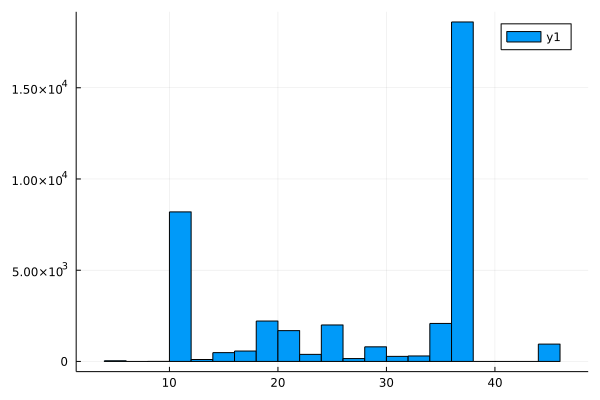

In [386]:
ftemp=filter(x->x>0,collect(skipmissing(xold.MBQ_Mutect_2) ) )
# ftemp = (ftemp .- Statistics.mean(ftemp)) ./ std(ftemp)
histogram(ftemp) 
# histogram!(filter(x->x>0,collect(skipmissing(xsnv.pon_pvalue_Vardict) ))) 

In [ ]:
"MBQ_Mutect_2" => 0.7985191494599996 # multinomial
"pon_pvalue_Vardict" => 0.07332121346287043 # beta
"gt_AF_Mutect" => 0.06109965883180721 # beta
"pon_pvalue_Lofreq" => 0.041306984948907784 # beta
"total_greater_than_min_alt_count_Vardict" => 0.011471085471493352 # multinomial
"PMEAN_Vardict" => 0.005081997366319203 # bimodal
"pon_pvalue_Mutect" => 0.0019495616104342826 # beta
"HICOV_Vardict" => 0.0005625514700339771 # bimodal
"MFRL_Mutect_2" => 0.0005211777149258403 # exp

In [394]:
y_tur = [i==true ? true : false for i in y];

In [397]:
xtur = copy(x[:,["MBQ_Mutect_2",
"pon_pvalue_Vardict",
"gt_AF_Mutect",
"pon_pvalue_Lofreq" ,
"total_greater_than_min_alt_count_Vardict",
"PMEAN_Vardict",
"pon_pvalue_Mutect",
"HICOV_Vardict",
"MFRL_Mutect_2"]]) 
# select(x, ["pon_pvalue_Vardict","ODDRATIO_Vardict","total_greater_than_min_alt_count_Lofreq",
#        "AltRev_Lofreq", "gt_AF_Mutect", "GERMQ_Mutect"]);

In [398]:
? Exponential()

```
Exponential(θ)
```

The *Exponential distribution* with scale parameter `θ` has probability density function

$$
f(x; \theta) = \frac{1}{\theta} e^{-\frac{x}{\theta}}, \quad x > 0
$$

```julia
Exponential()      # Exponential distribution with unit scale, i.e. Exponential(1)
Exponential(θ)     # Exponential distribution with scale θ

params(d)          # Get the parameters, i.e. (θ,)
scale(d)           # Get the scale parameter, i.e. θ
rate(d)            # Get the rate parameter, i.e. 1 / θ
```

External links

  * [Exponential distribution on Wikipedia](http://en.wikipedia.org/wiki/Exponential_distribution)


In [ ]:
1+1

In [406]:
@model function logistic_regression(x, y, n, σ)
    intercept ~ Normal(0, σ)
    
    p1 ~ Beta()
    p2 ~ Beta()
    p3 ~ Beta()
    p4 ~ Beta()
#     p5 ~ Beta()
#     p6 ~ MixtureModel(Normal[Normal(),Normal()])
#     p7 ~ Beta()
#     p8 ~ MixtureModel(Normal[Normal(),Normal()])
#     p9 ~ Exponential()
    
    for i = 1:n
#         v = logistic(intercept + sum(params .* Vector(x[i, :]) ) )
        v = logistic(intercept + p1 * x[i, 1] + p2 * x[i, 2] + p3 * x[i, 3] + p4 * x[i, 4] #+ p5 * x[i, 5] + 
          #  p6 * x[i, 6] + p7 * x[i, 7] + p8 * x[i, 8] + p9 * x[i, 9] 
        )
        y[i] ~ Bernoulli(v)
    end
end;

In [407]:
showtable(xtur[1:10,:])

WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol, Any}(:style => Dict("height" => "0", "padding" => "0", "background-color" => "#F5F7F7", "color" => "#1c1f20", "font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}(:id => "grid-e7147594", :className => "ag-theme-balham", :style => Dict("height" => "330px", "width" => "100%")))], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/src/rowNumberRenderer.js"), WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.js"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-light.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-dark.css")], Dict{Any, Any}(), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000109d8f750, Task (runnable) @0x0000000109d8f750), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"15224774283798520780\",\"id\":\"1573626279522487050\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"rowSelection\":\"multiple\",\"multiSortKey\":\"ctrl\",\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":true,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"MBQ_Mutect_2\",\"headerName\":\"MBQ_Mutect_2\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"pon_pvalue_Vardict\",\"headerName\":\"pon_pvalue_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"gt_AF_Mutect\",\"headerName\":\"gt_AF_Mutect\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"pon_pvalue_Lofreq\",\"headerName\":\"pon_pvalue_Lofreq\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"total_greater_than_min_alt_count_Vardict\",\"headerName\":\"total_greater_than_min_alt_count_Vardict\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"PMEAN_Vardict\",\"headerName\":\"PMEAN_Vardict\",\"sortable\":true,\"type\

In [ ]:
n = length(y_tur[1:5]) #["gt_AF_Vardict","gt_AF_Mutect","gt_AF_Lofreq","pon_pvalue_Vardict"]

# Sample using HMC.
m = logistic_regression(xtur[1:5,:], y_tur[train], n, 1)
chain = sample(m, HMC(0.2, 100), MCMCThreads(), 5, 3, progress=true)

# chain = sample(m, NUTS(50,0.65), MCMCThreads(), 100, 5, progress=true)
# describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/alexpanchot/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/alexpanchot/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47


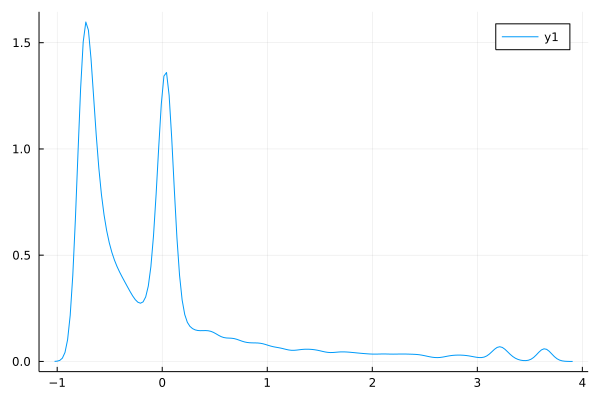

In [486]:
density(x.pon_pvalue_Vardict)

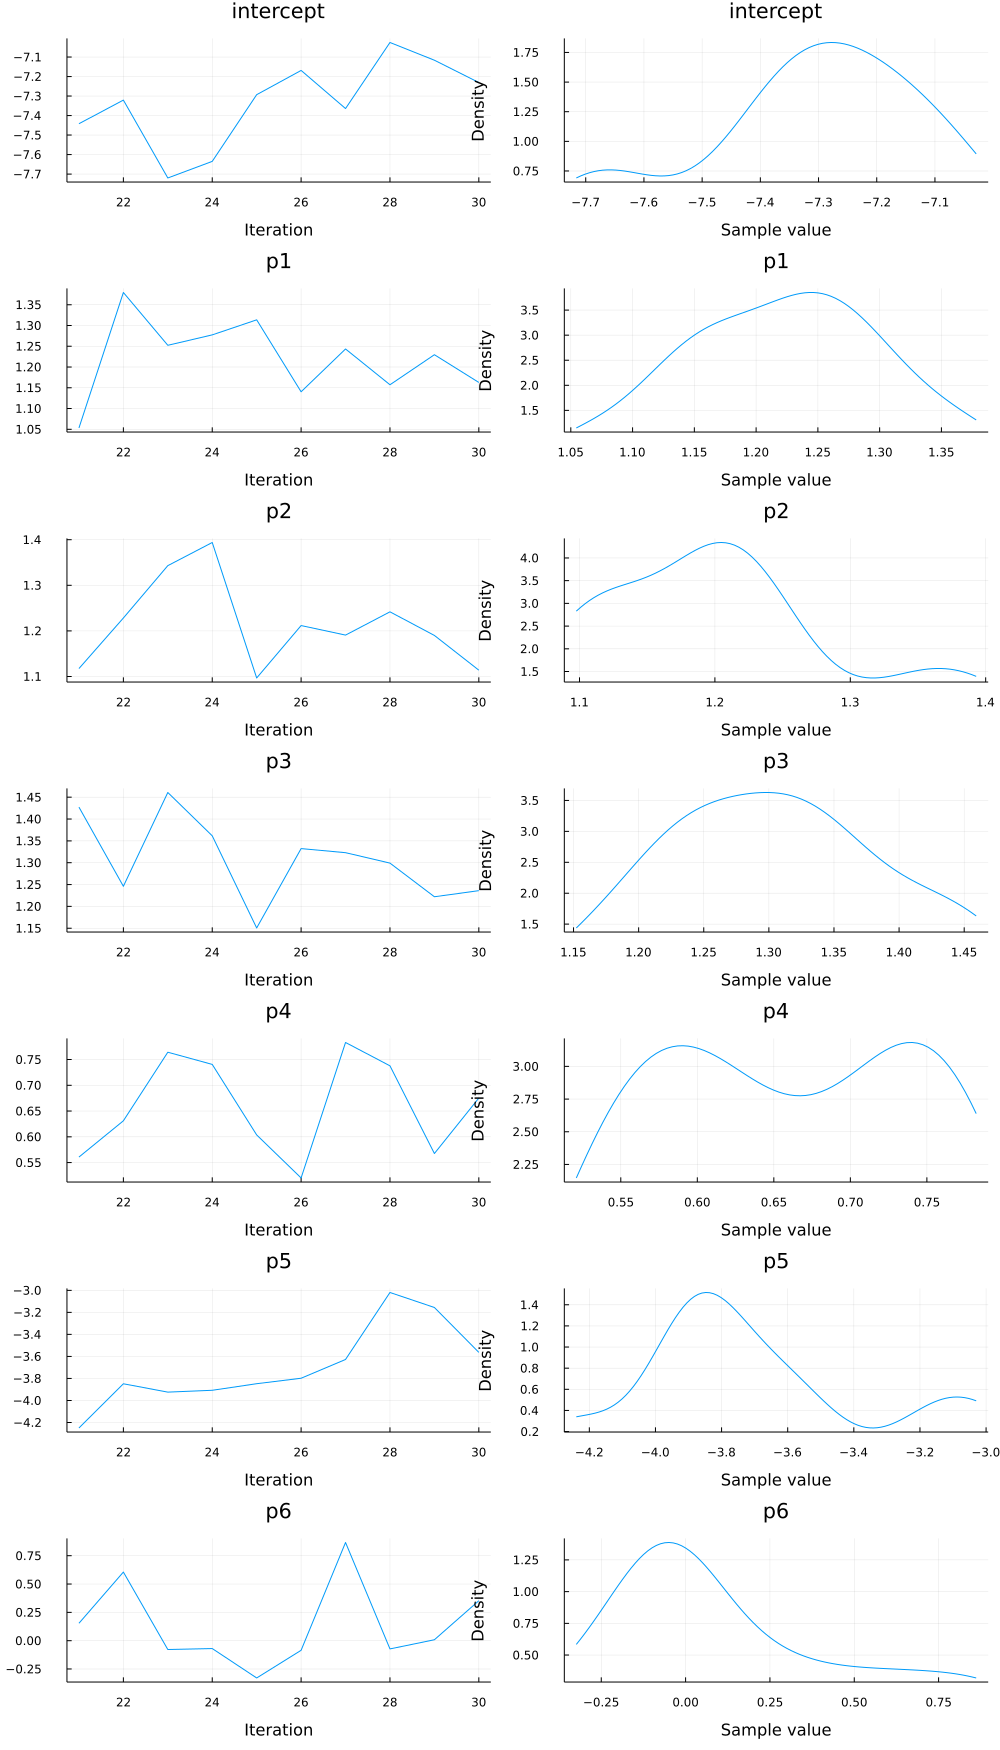

In [487]:
plot(chain)

In [488]:
NUTS()

search: NUTS ANUTS input_scitype DynamicNUTS ncodeunits InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, init_ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration.
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Int` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `init_ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [489]:
function prediction_turing(x, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    p1 = mean(chain[:p1])
    p2 = mean(chain[:p2])
    p3 = mean(chain[:p3])
    p4 = mean(chain[:p4])

    # Retrieve the number of rows.
    n = nrow(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        v[i] = logistic(intercept + p1*x[i, 1] + p2*x[i,2] + p3*x[i,3] + p4*x[i,4] )
    end
    return v
end;

In [490]:
ypred = prediction_turing(x[test,["gt_AF_Vardict","gt_AF_Mutect","gt_AF_Lofreq","pon_pvalue_Vardict"]],chain);

In [491]:
yhat2 = [i>.2 ? true : false for i in ypred];

In [492]:
MLJ.ConfusionMatrix()(yhat2,y[test])


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    5861     │     18      │
├─────────────┼─────────────┼─────────────┤
│    true     │     37      │      7      │
└─────────────┴─────────────┴─────────────┘


## GMM

In [348]:
using Distributions, StatsPlots, Random

# Set a random seed.
Random.seed!(3)

# Construct 30 data points for each cluster.
N = 30

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0]

# Construct the data points.
xds = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], 1.), N), hcat, 1:2)

# # Visualization.
# scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

2×60 Matrix{Float64}:
 -2.30844  -1.42519  -3.60161  -3.39921  …  0.297242  -0.821915  -0.821209
 -6.01973  -4.47325  -5.04251  -3.50197     0.399636  -0.520378  -0.508665

In [259]:
using Turing, MCMCChains

# Turn off the progress monitor.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/alexpanchot/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


In [260]:
@model function GaussianMixtureModel(x)

    D, N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()

    # Draw the parameters for cluster 2.
    μ2 ~ Normal()

    μ = [μ1, μ2]

    # Uncomment the following lines to draw the weights for the K clusters
    # from a Dirichlet distribution.

    # α = 1.0
    # w ~ Dirichlet(2, α)

    # Comment out this line if you instead want to draw the weights.
    w = [0.5, 0.5]

    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end;

In [271]:
gmm_model = GaussianMixtureModel(
#     x
    Matrix(Matrix(xtur[1:5,1:2])')
    );

In [ ]:
gmm_sampler = Gibbs(PG(10, :k), HMC(0.05, 10, :μ1, :μ2))
tchain = sample(gmm_model, gmm_sampler, MCMCThreads(), 10, 2);

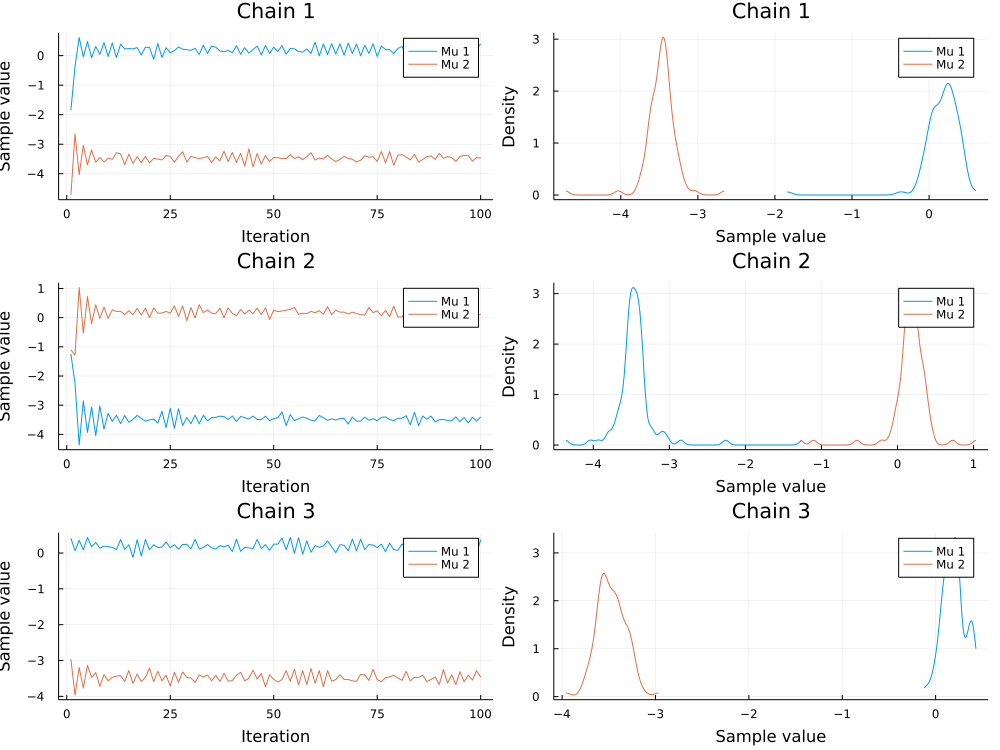

In [263]:
ids = findall(map(name -> occursin("μ", string(name)), names(tchain)));
p = plot(tchain[:, ids, :]; legend=true, labels=["Mu 1" "Mu 2"], colordim=:parameter)